# **Few-shot Pattern-Based Parameter Efficient Fine Tuning on RTE**

Paper being referred: "*Few-shot Fine-tuning vs. In-context Learning: A Fair Comparison and Evaluation*" (https://aclanthology.org/2023.findings-acl.779.pdf)

In [28]:
# Mount into drive

from google.colab import drive

drive.mount("/content/drive")

# Change directory to the package folder
#!! This should be the base directory of the project, this directory should look like the screenshot below.

%cd '/content/drive/MyDrive/DL/project/'

# Verify the contents of the current folder
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/DL/project
datafiles  notebooks  Results


# Set-up directories properly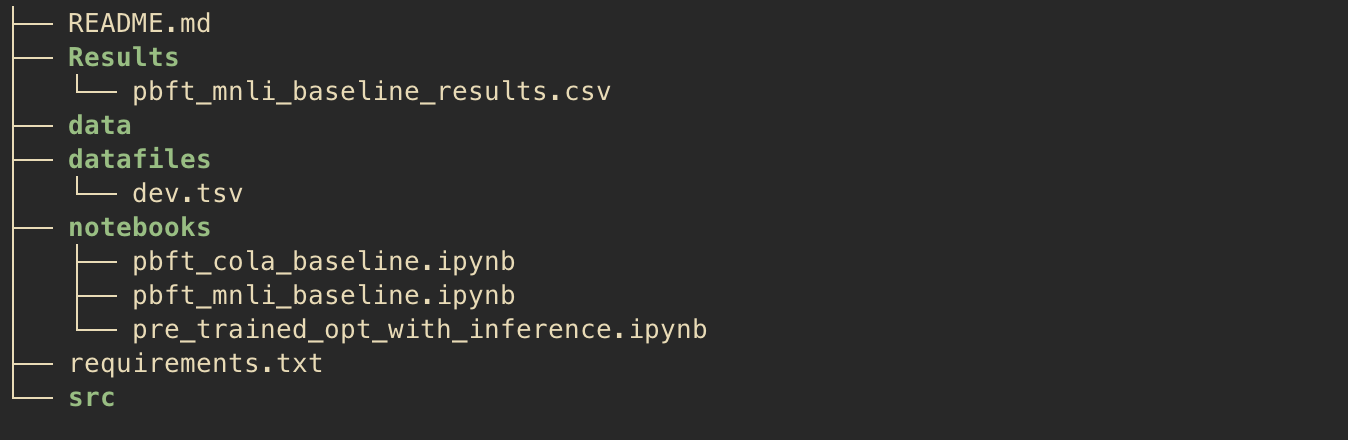

In [29]:
import os

from requests import get
from socket import gethostname, gethostbyname
ip = gethostbyname(gethostname())
curr_filename = get(f"http://{ip}:9000/api/sessions").json()[0]["name"]

# if there is no notebooks folder, create one and move the notebook to that folder and cd into it
if not os.path.exists('notebooks'):
  %mkdir notebooks
  %mv curr_filename notebooks/

%cd notebooks/

# check if "Results" folder exits in the base directly, else create one
if not os.path.exists('../Results'):
  %mkdir ../Results

!ls


/content/drive/MyDrive/DL/project/notebooks
pbft_cola_baseline.ipynb  pre_trained_opt.ipynb


In [30]:
!pip install -q transformers accelerate bitsandbytes datasets torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.5 MB/s eta 0:00:00


In [31]:
# Load required libraries

from datasets import load_dataset, ClassLabel
from sklearn.metrics import accuracy_score
from transformers import Trainer, TrainingArguments, AutoModelForSequenceClassification, AutoTokenizer, AdamW, AutoConfig
import numpy as np
import pandas as pd
import torch

In [32]:
# Set seed, load COLA dataset

torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

in_domain_data = load_dataset("glue", "cola") # COLA dataset (labels: (1) acceptable (2) not acceptable)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/8551 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1043 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1063 [00:00<?, ? examples/s]

# **Pre-processing code and function definitions**

In [33]:
# Deifine model and tokenizer

# Define the tokenizer
tokenizer = AutoTokenizer.from_pretrained("facebook/opt-125m")

# Set num_labels to 2 and drop-out hyperparam = 0.1
config = AutoConfig.from_pretrained("facebook/opt-125m", num_labels=2, hidden_dropout_prob=0.1, attention_probs_dropout_prob=0.1)
model = AutoModelForSequenceClassification.from_pretrained("facebook/opt-125m", config=config)


tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/651 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/251M [00:00<?, ?B/s]

Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
# Function to load and parse out-of-domain COLA dataset
'''
\cite: https://github.com/uds-lsv/llmft/blob/main/task_utils.py
'''
def load_cola_ood_dataset(path, label=None, cache_dir=None):
    data_files = {"validation": path}
    dataset = load_dataset("csv", data_files=data_files, sep="\t", column_names=[
                           'code', 'label', 'annotation', 'sentence'], cache_dir=cache_dir)
    dataset = dataset["validation"]

    # cola-ood comes without indices, so we add them
    indices = list(range(len(dataset)))
    dataset = dataset.add_column(name="idx", column=indices)

    subset = "cola-ood"

    if label is not None:  # filter dataset based on label
        dataset = dataset.filter(
            lambda example: example["label"] == label)
        subset = f"{subset}-{'acceptable' if label == 1 else 'unacceptable'}"

    return dataset, subset

In [35]:
# Deifne function for computing metric

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, predictions)}


In [36]:
# Manipulate data for decoder part of the model and add prompts relevant for CoLA

def manipulate_inputs_for_cola_with_prompt(inputs):
    # Add pattern/prompts
    inputs = tokenizer(["Yes or No?" + sentence for sentence in inputs["sentence"]], truncation=True, padding="max_length", max_length=128)

    return inputs

# augment in-domain-data
in_domain_data = in_domain_data.map(manipulate_inputs_for_cola_with_prompt, batched=True)

# augment out of domain data
eval_ood_data, _ = load_cola_ood_dataset(path='../datafiles/dev.tsv')
eval_ood_data = eval_ood_data.map(manipulate_inputs_for_cola_with_prompt, batched=True)

Map:   0%|          | 0/8551 [00:00<?, ? examples/s]

Map:   0%|          | 0/1043 [00:00<?, ? examples/s]

Map:   0%|          | 0/1063 [00:00<?, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/516 [00:00<?, ? examples/s]

In [37]:
# Define parameters for training experiments (per reference paper)

few_shot_sample_size = [2, 16, 32, 64, 128]  # number of examples for each class
num_epochs = 40
batch_size = 32
learning_rate = 1e-5
weight_decay = 0.
warmup_ratio = 0.1
num_runs = 10
optimizer = AdamW(model.parameters(), lr=learning_rate) # AdamW optimizer

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [38]:
# Vaiables to store training results into CSV
results_df = pd.DataFrame(columns=["n", "run", "in_domain_accuracy", "out_of_domain_accuracy"])

# **Experimentation loop**

In [39]:
for n in few_shot_sample_size:
    for run_idx in range(num_runs):  # repeat 10 times for each n
        # re-iniialize model for each run
        model = AutoModelForSequenceClassification.from_pretrained("facebook/opt-125m", config=config)
        optimizer = AdamW(model.parameters(), lr=learning_rate)

        # Select n random examples for each class from the original data
        indices_yes = np.where(np.array(in_domain_data["train"]["label"]) == 0)[0]
        indices_no = np.where(np.array(in_domain_data["train"]["label"]) == 1)[0]
        indices_yes = np.random.choice(indices_yes, n, replace=False)
        indices_no = np.random.choice(indices_no, n, replace=False)
        indices = np.concatenate([indices_yes, indices_no])

        # Select the examples for the new training set
        train_dataset = in_domain_data["train"].select(indices)

        # Define training config
        # Total steps = (#samples/batch size) * epochs
        total_steps = (len(train_dataset) // batch_size) * num_epochs

        training_args = TrainingArguments(
            output_dir = "./results",
            overwrite_output_dir = True,
            num_train_epochs = num_epochs,
            per_device_train_batch_size = batch_size,
            learning_rate = learning_rate,
            weight_decay = weight_decay,
            save_steps = 10_000,
            save_total_limit = 2,
            warmup_steps = int(warmup_ratio * total_steps),
        )

        # Define the trainer
        trainer = Trainer(
            model = model,
            args=training_args,
            train_dataset = train_dataset,
            compute_metrics = compute_metrics,
            optimizers=(optimizer, None),
        )

        # Train the model
        trainer.train()

        # Evaluate in-domain performance
        print(f"Evaluating in-domain performance for n={n}...")
        eval_results = trainer.evaluate(eval_dataset=in_domain_data["validation"])

        # Store the in-domain accuracy
        in_domain_accuracy = eval_results["eval_accuracy"]

        # Print the in-domain evaluation results
        for key, value in eval_results.items():
            print(f"In-domain {key}: {value}")

        # Evaluate out-of-domain performance
        print(f"Evaluating out-of-domain performance for n={n}...")
        eval_results = trainer.evaluate(eval_dataset=eval_ood_data)

        # Store the out-of-domain accuracy
        out_of_domain_accuracy = eval_results["eval_accuracy"]

        # Print the out-of-domain evaluation results
        for key, value in eval_results.items():
            print(f"Out-of-domain {key}: {value}")

        # Add the results to the DataFrame
        new_row = pd.DataFrame({
            "n": [n],
            "run": [run_idx],
            "in_domain_accuracy": [in_domain_accuracy],
            "out_of_domain_accuracy": [out_of_domain_accuracy]
        })
        results_df = pd.concat([results_df, new_row], ignore_index=True)

Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split

Step,Training Loss


Evaluating in-domain performance for n=2...


In-domain eval_loss: 0.8672010898590088
In-domain eval_accuracy: 0.5445829338446788
In-domain eval_runtime: 6.3437
In-domain eval_samples_per_second: 164.415
In-domain eval_steps_per_second: 20.65
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2...


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.853900134563446
Out-of-domain eval_accuracy: 0.560077519379845
Out-of-domain eval_runtime: 3.1994
Out-of-domain eval_samples_per_second: 161.282
Out-of-domain eval_steps_per_second: 20.317
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=2...


In-domain eval_loss: 0.8185608983039856
In-domain eval_accuracy: 0.5311601150527325
In-domain eval_runtime: 6.3765
In-domain eval_samples_per_second: 163.57
In-domain eval_steps_per_second: 20.544
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2...


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7890215516090393
Out-of-domain eval_accuracy: 0.5717054263565892
Out-of-domain eval_runtime: 3.2469
Out-of-domain eval_samples_per_second: 158.922
Out-of-domain eval_steps_per_second: 20.019
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=2...


In-domain eval_loss: 0.8185608983039856
In-domain eval_accuracy: 0.5311601150527325
In-domain eval_runtime: 6.4838
In-domain eval_samples_per_second: 160.862
In-domain eval_steps_per_second: 20.204
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2...


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7890215516090393
Out-of-domain eval_accuracy: 0.5717054263565892
Out-of-domain eval_runtime: 3.2933
Out-of-domain eval_samples_per_second: 156.679
Out-of-domain eval_steps_per_second: 19.737
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=2...


In-domain eval_loss: 0.8185608983039856
In-domain eval_accuracy: 0.5311601150527325
In-domain eval_runtime: 6.6055
In-domain eval_samples_per_second: 157.898
In-domain eval_steps_per_second: 19.832
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2...


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7890215516090393
Out-of-domain eval_accuracy: 0.5717054263565892
Out-of-domain eval_runtime: 3.3174
Out-of-domain eval_samples_per_second: 155.542
Out-of-domain eval_steps_per_second: 19.594
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=2...


In-domain eval_loss: 0.8185608983039856
In-domain eval_accuracy: 0.5311601150527325
In-domain eval_runtime: 6.6958
In-domain eval_samples_per_second: 155.77
In-domain eval_steps_per_second: 19.565
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2...


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7890215516090393
Out-of-domain eval_accuracy: 0.5717054263565892
Out-of-domain eval_runtime: 3.3822
Out-of-domain eval_samples_per_second: 152.562
Out-of-domain eval_steps_per_second: 19.218
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=2...


In-domain eval_loss: 0.8185608983039856
In-domain eval_accuracy: 0.5311601150527325
In-domain eval_runtime: 6.8178
In-domain eval_samples_per_second: 152.981
In-domain eval_steps_per_second: 19.214
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2...


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7890215516090393
Out-of-domain eval_accuracy: 0.5717054263565892
Out-of-domain eval_runtime: 3.4689
Out-of-domain eval_samples_per_second: 148.749
Out-of-domain eval_steps_per_second: 18.738
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=2...


In-domain eval_loss: 0.8185608983039856
In-domain eval_accuracy: 0.5311601150527325
In-domain eval_runtime: 6.9622
In-domain eval_samples_per_second: 149.81
In-domain eval_steps_per_second: 18.816
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2...


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7890215516090393
Out-of-domain eval_accuracy: 0.5717054263565892
Out-of-domain eval_runtime: 3.5104
Out-of-domain eval_samples_per_second: 146.992
Out-of-domain eval_steps_per_second: 18.516
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=2...


In-domain eval_loss: 0.8185608983039856
In-domain eval_accuracy: 0.5311601150527325
In-domain eval_runtime: 7.0799
In-domain eval_samples_per_second: 147.319
In-domain eval_steps_per_second: 18.503
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2...


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7890215516090393
Out-of-domain eval_accuracy: 0.5717054263565892
Out-of-domain eval_runtime: 3.5697
Out-of-domain eval_samples_per_second: 144.548
Out-of-domain eval_steps_per_second: 18.209
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=2...


In-domain eval_loss: 0.8185608983039856
In-domain eval_accuracy: 0.5311601150527325
In-domain eval_runtime: 7.2159
In-domain eval_samples_per_second: 144.542
In-domain eval_steps_per_second: 18.154
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2...


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7890215516090393
Out-of-domain eval_accuracy: 0.5717054263565892
Out-of-domain eval_runtime: 3.6601
Out-of-domain eval_samples_per_second: 140.979
Out-of-domain eval_steps_per_second: 17.759
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=2...


In-domain eval_loss: 0.8185608983039856
In-domain eval_accuracy: 0.5311601150527325
In-domain eval_runtime: 7.2197
In-domain eval_samples_per_second: 144.466
In-domain eval_steps_per_second: 18.145
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2...


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.7890215516090393
Out-of-domain eval_accuracy: 0.5717054263565892
Out-of-domain eval_runtime: 3.6133
Out-of-domain eval_samples_per_second: 142.806
Out-of-domain eval_steps_per_second: 17.989
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=16...


In-domain eval_loss: 0.9753984212875366
In-domain eval_accuracy: 0.4947267497603068
In-domain eval_runtime: 7.0915
In-domain eval_samples_per_second: 147.078
In-domain eval_steps_per_second: 18.473
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16...


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.9640471935272217
Out-of-domain eval_accuracy: 0.5058139534883721
Out-of-domain eval_runtime: 3.5645
Out-of-domain eval_samples_per_second: 144.761
Out-of-domain eval_steps_per_second: 18.235
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=16...


In-domain eval_loss: 0.9753984212875366
In-domain eval_accuracy: 0.4947267497603068
In-domain eval_runtime: 7.1781
In-domain eval_samples_per_second: 145.303
In-domain eval_steps_per_second: 18.25
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16...


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.9640471935272217
Out-of-domain eval_accuracy: 0.5058139534883721
Out-of-domain eval_runtime: 3.5947
Out-of-domain eval_samples_per_second: 143.545
Out-of-domain eval_steps_per_second: 18.082
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=16...


In-domain eval_loss: 0.9753984212875366
In-domain eval_accuracy: 0.4947267497603068
In-domain eval_runtime: 7.1332
In-domain eval_samples_per_second: 146.217
In-domain eval_steps_per_second: 18.365
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16...


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.9640471935272217
Out-of-domain eval_accuracy: 0.5058139534883721
Out-of-domain eval_runtime: 3.5743
Out-of-domain eval_samples_per_second: 144.365
Out-of-domain eval_steps_per_second: 18.186
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=16...


In-domain eval_loss: 0.9753984212875366
In-domain eval_accuracy: 0.4947267497603068
In-domain eval_runtime: 7.1531
In-domain eval_samples_per_second: 145.812
In-domain eval_steps_per_second: 18.314
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16...


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.9640471935272217
Out-of-domain eval_accuracy: 0.5058139534883721
Out-of-domain eval_runtime: 3.5891
Out-of-domain eval_samples_per_second: 143.767
Out-of-domain eval_steps_per_second: 18.11
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=16...


In-domain eval_loss: 0.9753984212875366
In-domain eval_accuracy: 0.4947267497603068
In-domain eval_runtime: 7.1232
In-domain eval_samples_per_second: 146.423
In-domain eval_steps_per_second: 18.391
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16...


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.9640471935272217
Out-of-domain eval_accuracy: 0.5058139534883721
Out-of-domain eval_runtime: 3.576
Out-of-domain eval_samples_per_second: 144.294
Out-of-domain eval_steps_per_second: 18.177
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=16...


In-domain eval_loss: 0.9753984212875366
In-domain eval_accuracy: 0.4947267497603068
In-domain eval_runtime: 7.1391
In-domain eval_samples_per_second: 146.097
In-domain eval_steps_per_second: 18.35
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16...


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.9640471935272217
Out-of-domain eval_accuracy: 0.5058139534883721
Out-of-domain eval_runtime: 3.5947
Out-of-domain eval_samples_per_second: 143.545
Out-of-domain eval_steps_per_second: 18.082
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=16...


In-domain eval_loss: 0.9753984212875366
In-domain eval_accuracy: 0.4947267497603068
In-domain eval_runtime: 7.1407
In-domain eval_samples_per_second: 146.064
In-domain eval_steps_per_second: 18.345
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16...


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.9640471935272217
Out-of-domain eval_accuracy: 0.5058139534883721
Out-of-domain eval_runtime: 3.5905
Out-of-domain eval_samples_per_second: 143.712
Out-of-domain eval_steps_per_second: 18.103
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=16...


In-domain eval_loss: 0.9753984212875366
In-domain eval_accuracy: 0.4947267497603068
In-domain eval_runtime: 7.1474
In-domain eval_samples_per_second: 145.928
In-domain eval_steps_per_second: 18.328
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16...


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.9640471935272217
Out-of-domain eval_accuracy: 0.5058139534883721
Out-of-domain eval_runtime: 3.5875
Out-of-domain eval_samples_per_second: 143.834
Out-of-domain eval_steps_per_second: 18.119
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=16...


In-domain eval_loss: 0.9753984212875366
In-domain eval_accuracy: 0.4947267497603068
In-domain eval_runtime: 7.1485
In-domain eval_samples_per_second: 145.904
In-domain eval_steps_per_second: 18.325
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16...


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.9640471935272217
Out-of-domain eval_accuracy: 0.5058139534883721
Out-of-domain eval_runtime: 3.5975
Out-of-domain eval_samples_per_second: 143.435
Out-of-domain eval_steps_per_second: 18.068
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=16...


In-domain eval_loss: 0.9753984212875366
In-domain eval_accuracy: 0.4947267497603068
In-domain eval_runtime: 7.1392
In-domain eval_samples_per_second: 146.096
In-domain eval_steps_per_second: 18.35
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=16...


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 0.9640471935272217
Out-of-domain eval_accuracy: 0.5058139534883721
Out-of-domain eval_runtime: 3.6025
Out-of-domain eval_samples_per_second: 143.235
Out-of-domain eval_steps_per_second: 18.043
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=32...


In-domain eval_loss: 1.4189616441726685
In-domain eval_accuracy: 0.5148609779482263
In-domain eval_runtime: 7.1425
In-domain eval_samples_per_second: 146.027
In-domain eval_steps_per_second: 18.341
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32...


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 1.3532181978225708
Out-of-domain eval_accuracy: 0.5213178294573644
Out-of-domain eval_runtime: 3.6037
Out-of-domain eval_samples_per_second: 143.187
Out-of-domain eval_steps_per_second: 18.037
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=32...


In-domain eval_loss: 2.4980039596557617
In-domain eval_accuracy: 0.45158197507190795
In-domain eval_runtime: 7.1261
In-domain eval_samples_per_second: 146.362
In-domain eval_steps_per_second: 18.383
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32...


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 2.491607904434204
Out-of-domain eval_accuracy: 0.44573643410852715
Out-of-domain eval_runtime: 3.5765
Out-of-domain eval_samples_per_second: 144.273
Out-of-domain eval_steps_per_second: 18.174
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=32...


In-domain eval_loss: 2.4980039596557617
In-domain eval_accuracy: 0.45158197507190795
In-domain eval_runtime: 7.1422
In-domain eval_samples_per_second: 146.033
In-domain eval_steps_per_second: 18.342
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32...


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 2.491607904434204
Out-of-domain eval_accuracy: 0.44573643410852715
Out-of-domain eval_runtime: 3.6054
Out-of-domain eval_samples_per_second: 143.119
Out-of-domain eval_steps_per_second: 18.029
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=32...


In-domain eval_loss: 2.4980039596557617
In-domain eval_accuracy: 0.45158197507190795
In-domain eval_runtime: 7.1544
In-domain eval_samples_per_second: 145.784
In-domain eval_steps_per_second: 18.31
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32...


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 2.491607904434204
Out-of-domain eval_accuracy: 0.44573643410852715
Out-of-domain eval_runtime: 3.5762
Out-of-domain eval_samples_per_second: 144.289
Out-of-domain eval_steps_per_second: 18.176
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=32...


In-domain eval_loss: 2.4980039596557617
In-domain eval_accuracy: 0.45158197507190795
In-domain eval_runtime: 7.1369
In-domain eval_samples_per_second: 146.142
In-domain eval_steps_per_second: 18.355
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32...


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 2.491607904434204
Out-of-domain eval_accuracy: 0.44573643410852715
Out-of-domain eval_runtime: 3.5882
Out-of-domain eval_samples_per_second: 143.806
Out-of-domain eval_steps_per_second: 18.115
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=32...


In-domain eval_loss: 2.4980039596557617
In-domain eval_accuracy: 0.45158197507190795
In-domain eval_runtime: 7.1273
In-domain eval_samples_per_second: 146.339
In-domain eval_steps_per_second: 18.38
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32...


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 2.491607904434204
Out-of-domain eval_accuracy: 0.44573643410852715
Out-of-domain eval_runtime: 3.592
Out-of-domain eval_samples_per_second: 143.652
Out-of-domain eval_steps_per_second: 18.096
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=32...


In-domain eval_loss: 2.4980039596557617
In-domain eval_accuracy: 0.45158197507190795
In-domain eval_runtime: 7.1673
In-domain eval_samples_per_second: 145.522
In-domain eval_steps_per_second: 18.278
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32...


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 2.491607904434204
Out-of-domain eval_accuracy: 0.44573643410852715
Out-of-domain eval_runtime: 3.5942
Out-of-domain eval_samples_per_second: 143.566
Out-of-domain eval_steps_per_second: 18.085
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=32...


In-domain eval_loss: 2.4980039596557617
In-domain eval_accuracy: 0.45158197507190795
In-domain eval_runtime: 7.1457
In-domain eval_samples_per_second: 145.961
In-domain eval_steps_per_second: 18.333
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32...


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 2.491607904434204
Out-of-domain eval_accuracy: 0.44573643410852715
Out-of-domain eval_runtime: 3.6036
Out-of-domain eval_samples_per_second: 143.19
Out-of-domain eval_steps_per_second: 18.037
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=32...


In-domain eval_loss: 2.4980039596557617
In-domain eval_accuracy: 0.45158197507190795
In-domain eval_runtime: 7.1348
In-domain eval_samples_per_second: 146.185
In-domain eval_steps_per_second: 18.361
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32...


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 2.491607904434204
Out-of-domain eval_accuracy: 0.44573643410852715
Out-of-domain eval_runtime: 3.5685
Out-of-domain eval_samples_per_second: 144.6
Out-of-domain eval_steps_per_second: 18.215
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=32...


In-domain eval_loss: 2.4980039596557617
In-domain eval_accuracy: 0.45158197507190795
In-domain eval_runtime: 7.1431
In-domain eval_samples_per_second: 146.015
In-domain eval_steps_per_second: 18.339
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32...


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 2.491607904434204
Out-of-domain eval_accuracy: 0.44573643410852715
Out-of-domain eval_runtime: 3.5846
Out-of-domain eval_samples_per_second: 143.948
Out-of-domain eval_steps_per_second: 18.133
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=64...


In-domain eval_loss: 3.3955705165863037
In-domain eval_accuracy: 0.5254074784276127
In-domain eval_runtime: 7.1093
In-domain eval_samples_per_second: 146.709
In-domain eval_steps_per_second: 18.427
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64...


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 3.393465518951416
Out-of-domain eval_accuracy: 0.5155038759689923
Out-of-domain eval_runtime: 3.572
Out-of-domain eval_samples_per_second: 144.457
Out-of-domain eval_steps_per_second: 18.197
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=64...


In-domain eval_loss: 2.8588783740997314
In-domain eval_accuracy: 0.5532118887823586
In-domain eval_runtime: 7.135
In-domain eval_samples_per_second: 146.181
In-domain eval_steps_per_second: 18.36
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64...


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 2.830016613006592
Out-of-domain eval_accuracy: 0.5523255813953488
Out-of-domain eval_runtime: 3.5876
Out-of-domain eval_samples_per_second: 143.828
Out-of-domain eval_steps_per_second: 18.118
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=64...


In-domain eval_loss: 2.8588783740997314
In-domain eval_accuracy: 0.5532118887823586
In-domain eval_runtime: 7.1345
In-domain eval_samples_per_second: 146.191
In-domain eval_steps_per_second: 18.361
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64...


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 2.830016613006592
Out-of-domain eval_accuracy: 0.5523255813953488
Out-of-domain eval_runtime: 3.593
Out-of-domain eval_samples_per_second: 143.612
Out-of-domain eval_steps_per_second: 18.091
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=64...


In-domain eval_loss: 2.8588783740997314
In-domain eval_accuracy: 0.5532118887823586
In-domain eval_runtime: 7.0938
In-domain eval_samples_per_second: 147.03
In-domain eval_steps_per_second: 18.467
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64...


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 2.830016613006592
Out-of-domain eval_accuracy: 0.5523255813953488
Out-of-domain eval_runtime: 3.5922
Out-of-domain eval_samples_per_second: 143.644
Out-of-domain eval_steps_per_second: 18.095
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=64...


In-domain eval_loss: 2.8588783740997314
In-domain eval_accuracy: 0.5532118887823586
In-domain eval_runtime: 7.117
In-domain eval_samples_per_second: 146.551
In-domain eval_steps_per_second: 18.407
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64...


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 2.830016613006592
Out-of-domain eval_accuracy: 0.5523255813953488
Out-of-domain eval_runtime: 3.5651
Out-of-domain eval_samples_per_second: 144.737
Out-of-domain eval_steps_per_second: 18.232
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=64...


In-domain eval_loss: 2.8588783740997314
In-domain eval_accuracy: 0.5532118887823586
In-domain eval_runtime: 7.1038
In-domain eval_samples_per_second: 146.824
In-domain eval_steps_per_second: 18.441
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64...


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 2.830016613006592
Out-of-domain eval_accuracy: 0.5523255813953488
Out-of-domain eval_runtime: 3.5727
Out-of-domain eval_samples_per_second: 144.429
Out-of-domain eval_steps_per_second: 18.194
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=64...


In-domain eval_loss: 2.8588783740997314
In-domain eval_accuracy: 0.5532118887823586
In-domain eval_runtime: 7.1268
In-domain eval_samples_per_second: 146.349
In-domain eval_steps_per_second: 18.381
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64...


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 2.830016613006592
Out-of-domain eval_accuracy: 0.5523255813953488
Out-of-domain eval_runtime: 3.5748
Out-of-domain eval_samples_per_second: 144.343
Out-of-domain eval_steps_per_second: 18.183
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=64...


In-domain eval_loss: 2.8588783740997314
In-domain eval_accuracy: 0.5532118887823586
In-domain eval_runtime: 7.1084
In-domain eval_samples_per_second: 146.727
In-domain eval_steps_per_second: 18.429
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64...


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 2.830016613006592
Out-of-domain eval_accuracy: 0.5523255813953488
Out-of-domain eval_runtime: 3.5623
Out-of-domain eval_samples_per_second: 144.849
Out-of-domain eval_steps_per_second: 18.246
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=64...


In-domain eval_loss: 2.8588783740997314
In-domain eval_accuracy: 0.5532118887823586
In-domain eval_runtime: 7.1074
In-domain eval_samples_per_second: 146.749
In-domain eval_steps_per_second: 18.432
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64...


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 2.830016613006592
Out-of-domain eval_accuracy: 0.5523255813953488
Out-of-domain eval_runtime: 3.5879
Out-of-domain eval_samples_per_second: 143.817
Out-of-domain eval_steps_per_second: 18.116
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=64...


In-domain eval_loss: 2.8588783740997314
In-domain eval_accuracy: 0.5532118887823586
In-domain eval_runtime: 7.1084
In-domain eval_samples_per_second: 146.727
In-domain eval_steps_per_second: 18.429
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=64...


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 2.830016613006592
Out-of-domain eval_accuracy: 0.5523255813953488
Out-of-domain eval_runtime: 3.5686
Out-of-domain eval_samples_per_second: 144.596
Out-of-domain eval_steps_per_second: 18.215
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=128...


In-domain eval_loss: 2.9655306339263916
In-domain eval_accuracy: 0.6251198465963567
In-domain eval_runtime: 7.1096
In-domain eval_samples_per_second: 146.703
In-domain eval_steps_per_second: 18.426
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128...


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 2.9015281200408936
Out-of-domain eval_accuracy: 0.625968992248062
Out-of-domain eval_runtime: 3.5541
Out-of-domain eval_samples_per_second: 145.185
Out-of-domain eval_steps_per_second: 18.289
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=128...


In-domain eval_loss: 2.5445468425750732
In-domain eval_accuracy: 0.6414189837008629
In-domain eval_runtime: 7.1257
In-domain eval_samples_per_second: 146.373
In-domain eval_steps_per_second: 18.384
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128...


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 2.4546854496002197
Out-of-domain eval_accuracy: 0.6317829457364341
Out-of-domain eval_runtime: 3.5929
Out-of-domain eval_samples_per_second: 143.618
Out-of-domain eval_steps_per_second: 18.091
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Step,Training Loss


Evaluating in-domain performance for n=128...


In-domain eval_loss: 2.5445468425750732
In-domain eval_accuracy: 0.6414189837008629
In-domain eval_runtime: 7.1262
In-domain eval_samples_per_second: 146.361
In-domain eval_steps_per_second: 18.383
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128...


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 2.4546854496002197
Out-of-domain eval_accuracy: 0.6317829457364341
Out-of-domain eval_runtime: 3.5689
Out-of-domain eval_samples_per_second: 144.583
Out-of-domain eval_steps_per_second: 18.213
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=128...


In-domain eval_loss: 2.5445468425750732
In-domain eval_accuracy: 0.6414189837008629
In-domain eval_runtime: 7.1129
In-domain eval_samples_per_second: 146.634
In-domain eval_steps_per_second: 18.417
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128...


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 2.4546854496002197
Out-of-domain eval_accuracy: 0.6317829457364341
Out-of-domain eval_runtime: 3.5873
Out-of-domain eval_samples_per_second: 143.841
Out-of-domain eval_steps_per_second: 18.12
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=128...


In-domain eval_loss: 2.5445468425750732
In-domain eval_accuracy: 0.6414189837008629
In-domain eval_runtime: 7.1195
In-domain eval_samples_per_second: 146.498
In-domain eval_steps_per_second: 18.4
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128...


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 2.4546854496002197
Out-of-domain eval_accuracy: 0.6317829457364341
Out-of-domain eval_runtime: 3.5757
Out-of-domain eval_samples_per_second: 144.309
Out-of-domain eval_steps_per_second: 18.178
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=128...


In-domain eval_loss: 2.5445468425750732
In-domain eval_accuracy: 0.6414189837008629
In-domain eval_runtime: 7.1397
In-domain eval_samples_per_second: 146.084
In-domain eval_steps_per_second: 18.348
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128...


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 2.4546854496002197
Out-of-domain eval_accuracy: 0.6317829457364341
Out-of-domain eval_runtime: 3.5739
Out-of-domain eval_samples_per_second: 144.382
Out-of-domain eval_steps_per_second: 18.188
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=128...


In-domain eval_loss: 2.5445468425750732
In-domain eval_accuracy: 0.6414189837008629
In-domain eval_runtime: 7.1248
In-domain eval_samples_per_second: 146.391
In-domain eval_steps_per_second: 18.387
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128...


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 2.4546854496002197
Out-of-domain eval_accuracy: 0.6317829457364341
Out-of-domain eval_runtime: 3.5756
Out-of-domain eval_samples_per_second: 144.311
Out-of-domain eval_steps_per_second: 18.179
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=128...


In-domain eval_loss: 2.5445468425750732
In-domain eval_accuracy: 0.6414189837008629
In-domain eval_runtime: 7.1262
In-domain eval_samples_per_second: 146.36
In-domain eval_steps_per_second: 18.383
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128...


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 2.4546854496002197
Out-of-domain eval_accuracy: 0.6317829457364341
Out-of-domain eval_runtime: 3.5665
Out-of-domain eval_samples_per_second: 144.678
Out-of-domain eval_steps_per_second: 18.225
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=128...


In-domain eval_loss: 2.5445468425750732
In-domain eval_accuracy: 0.6414189837008629
In-domain eval_runtime: 7.1424
In-domain eval_samples_per_second: 146.029
In-domain eval_steps_per_second: 18.341
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128...


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Out-of-domain eval_loss: 2.4546854496002197
Out-of-domain eval_accuracy: 0.6317829457364341
Out-of-domain eval_runtime: 3.5921
Out-of-domain eval_samples_per_second: 143.649
Out-of-domain eval_steps_per_second: 18.095
Out-of-domain epoch: 40.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


Evaluating in-domain performance for n=128...


In-domain eval_loss: 2.5445468425750732
In-domain eval_accuracy: 0.6414189837008629
In-domain eval_runtime: 7.136
In-domain eval_samples_per_second: 146.16
In-domain eval_steps_per_second: 18.358
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128...
Out-of-domain eval_loss: 2.4546854496002197
Out-of-domain eval_accuracy: 0.6317829457364341
Out-of-domain eval_runtime: 3.5783
Out-of-domain eval_samples_per_second: 144.204
Out-of-domain eval_steps_per_second: 18.165
Out-of-domain epoch: 40.0


In [40]:
# **Results post-processing**

In [41]:
# Group the results by number of examples in few-shot learning runs and compute the average and maximum performance for each group
grouped_results = results_df.groupby('n')

average_in_domain_accuracy = grouped_results['in_domain_accuracy'].mean()
maximum_in_domain_accuracy = grouped_results['in_domain_accuracy'].max()

average_out_of_domain_accuracy = grouped_results['out_of_domain_accuracy'].mean()
maximum_out_of_domain_accuracy = grouped_results['out_of_domain_accuracy'].max()

# Print the results for each 'n'
for n in few_shot_sample_size:
    print(f"For n={n}:")
    print(f"Average in-domain accuracy: {average_in_domain_accuracy[n]}")
    print(f"Maximum in-domain accuracy: {maximum_in_domain_accuracy[n]}")
    print(f"Average out-of-domain accuracy: {average_out_of_domain_accuracy[n]}")
    print(f"Maximum out-of-domain accuracy: {maximum_out_of_domain_accuracy[n]}")
    print("\n")

# Compute and print the overall average and maximum performance
print("Overall:")
print(f"Average in-domain accuracy: {results_df['in_domain_accuracy'].mean()}")
print(f"Maximum in-domain accuracy: {results_df['in_domain_accuracy'].max()}")
print(f"Average out-of-domain accuracy: {results_df['out_of_domain_accuracy'].mean()}")
print(f"Maximum out-of-domain accuracy: {results_df['out_of_domain_accuracy'].max()}")


For n=2:
Average in-domain accuracy: 0.5325023969319271
Maximum in-domain accuracy: 0.5445829338446788
Average out-of-domain accuracy: 0.5705426356589147
Maximum out-of-domain accuracy: 0.5717054263565892


For n=16:
Average in-domain accuracy: 0.49472674976030684
Maximum in-domain accuracy: 0.4947267497603068
Average out-of-domain accuracy: 0.5058139534883721
Maximum out-of-domain accuracy: 0.5058139534883721


For n=32:
Average in-domain accuracy: 0.45790987535953975
Maximum in-domain accuracy: 0.5148609779482263
Average out-of-domain accuracy: 0.4532945736434109
Maximum out-of-domain accuracy: 0.5213178294573644


For n=64:
Average in-domain accuracy: 0.550431447746884
Maximum in-domain accuracy: 0.5532118887823586
Average out-of-domain accuracy: 0.5486434108527132
Maximum out-of-domain accuracy: 0.5523255813953488


For n=128:
Average in-domain accuracy: 0.6397890699904123
Maximum in-domain accuracy: 0.6414189837008629
Average out-of-domain accuracy: 0.631201550387597
Maximum out-o

In [ ]:
# Save the DataFrame to a CSV file
results_df.to_csv(f'../Results/{curr_filename}.csv', sep = ',', index=False)

In [43]:
# disconnect runtime
from google.colab import runtime
runtime.unassign()